## Required packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Input
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample
from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance

In [72]:
def summary_statistics(arr):
    # calculates summary statistics from array
    
    return [np.min(arr),np.max(arr),np.mean(arr), np.std(arr),np.quantile(arr,0.25),np.quantile(arr,0.5),np.quantile(arr,0.75),np.quantile(arr,0.75)-np.quantile(arr,0.25)]

def normalize(arr):
    #Normalize an array so that the sum equals to 1.
    
    soma=0
    
    for i in range(len(arr)):
            soma+=arr[i]
    return arr/soma

def set_1D_intersection(arr1,arr2):
    # Calculate the intersection between two 1D intervals [a,b] [c,d]
    
    r=[] # intersection result
    
    if arr2[0] > arr1[1] or arr1[0]>arr2[1]:
        
        return r
    else:
        r.append(max(arr1[0],arr2[0]))
        r.append(min(arr1[1],arr2[1]))
        
    return r

def set_1D_union(arr1,arr2):
    # Calculates the union between two 1D intervals [a,b] [c,d]
    
    r=[] # union result
    
    r.append(min(arr1[0],arr2[0]))
    r.append(max(arr1[1],arr2[1]))
        
    return r

def intersection_over_union1D(arr1,arr2):
    # Computes the overlap over union. Lies in (0,1)
    
    inter=set_1D_intersection(arr1,arr2)
    union=set_1D_union(arr1,arr2)
    
    if not inter:
        return 0
    
    return ((inter[1]-inter[0])/(union[1]-union[0]))

T=100 # number of trials

lst_results=[] # list to store interval width summary statistics across T trials


lst_coverages=[]  # list to store coverage summary statistics across T trials


plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size': 25})
sns.set_style("darkgrid", {'axes.grid' : True})

In [73]:
#load the data

data=pd.read_csv('hour.csv')
print(data.shape)
data.head(10)

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [74]:
#check if there any missing value
data.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [75]:
#drop irrelevant columns and move the target (price) to the last position

#target=data['price'].values # shares

data = data.drop(columns=['instant','dteday'],axis=1)
data['cnt']=data['cnt'].astype(np.float64)
#data.insert(data.shape[1], 'price', target)
data.head(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16.0
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40.0
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32.0
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13.0
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1.0
5,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1.0
6,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2.0
7,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3.0
8,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8.0
9,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14.0


In [76]:
X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

# Load boston housing prices dataset
#d=load_boston()
#X=d['data']
#y=d['target']

#Split the dataset in 3 mutually exclusive datasets, train, calibatrion and evaluation (for assessement)

def train_cal_test_split(X,y,random_state=22):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
    X_cal,X_val,y_cal,y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    
    return X_train,y_train,X_cal,y_cal,X_val,y_val

In [77]:
X_train,y_train,X_cal,y_cal,X_val,y_val=train_cal_test_split(X,y)

In [78]:
scaler_X=MinMaxScaler()
X_train=scaler_X.fit_transform(X_train)
X_cal=scaler_X.transform(X_cal)
X_val=scaler_X.transform(X_val)

In [79]:
#quantile loss function

def tilted_loss(q,y,f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted (predicted) value.
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

# Feedforward neural network QR architecture

def QuantileRegressionModel(X_train,y_train,T,qs=[0.05,0.5,0.95],n_layers=2,n_neurons=100,decay_rate=0.5,activation='relu',optimizer='adam',epochs=1000,batch_size=1000,verbose=0):
    # T: # of repetitions
    # qs quantiles to estimate
    # n_layers: number of hidden layers
    # n_neurons: number of neurons per layer (multiplied by decay_rate)
    # activation: activation function
    # optimizer: optimization algorithm
    # epochs: number of times the training set is read in the optimization process
    # batch_size: number of examples seen before updating the weights
    # verbose : ignore or show the outputs during optimization 
    
    models=[]
    
    for i in tqdm(range(T)):

        ipt_layer = Input((X_train.shape[1],))
        layer1 = Dense(n_neurons, activation=activation)(ipt_layer)

        previous_layer=layer1

        for i in range(n_layers):
            next_layer = Dense(max(int((decay_rate**(i+1))*(n_neurons)),1), activation=activation)(previous_layer)
            previous_layer=next_layer

        out1 = Dense(1, name='out1')(previous_layer)
        out2 = Dense(1, name='out2')(previous_layer)
        out3 = Dense(1, name='out3')(previous_layer)

        q1, q2, q3 = qs
        model = Model(inputs=ipt_layer, outputs=[out1, out2, out3])
        model.compile(loss={'out1': lambda y,f: tilted_loss(q1,y,f),
                            'out2': lambda y,f: tilted_loss(q2,y,f),
                            'out3': lambda y,f: tilted_loss(q3,y,f),}, 
                      loss_weights={'out1': 1, 'out2': 1, 'out3': 1},
                     optimizer=optimizer)



        model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        models.append(model)
    
    return models
    

In [80]:
def permutation_importance(model,X_train,y_train,X_cal,y_cal,n_repeats):
    # model: trained ML model
    # X_train: Explanatory variables training set
    # y_train: Response variables for training
    # X_cal: Explanatory variables for evaluation (calculate decrease in importance)
    # y_cal: Response variables for evaluation (calculate decrease in importance)
    # n_repeats: Number of repetitions to shuffle each column and then average the difference
    
    n_features=X_train.shape[1]
    feature_importances=np.zeros((n_repeats,n_features))
    true_indexes = np.arange(n_features)
    
    for j in tqdm(range(n_features)):
        for i in range(n_repeats):
            X_cal_permuted=np.copy(X_cal)
            X_cal_permuted[:,j]=resample(X_cal_permuted[:,j])
            y_pred=model.predict(X_cal)[1].flatten()
            y_pred_permuted=model.predict(X_cal_permuted)[1].flatten()
            mae= mean_absolute_error(y_pred,y_cal)
            mae_perm=mean_absolute_error(y_pred_permuted,y_cal)
            diff=np.abs(mae_perm-mae)
            feature_importances[i,j]= diff
        
    return np.mean(feature_importances,axis=0)

In [81]:
models=QuantileRegressionModel(X_train,y_train,T)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:09:51<00:00, 41.92s/it]


In [82]:
feature_importance=permutation_importance(models[0],X_train,y_train,X_cal,y_cal,15)
feature_importance

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:41<00:00,  7.22s/it]


array([7.75155837e-02, 2.22438608e-02, 5.25101473e-02, 1.17922244e-03,
       7.79698340e-03, 4.24004999e-03, 3.23169721e-03, 5.58891966e-04,
       3.42124827e-02, 2.67406805e-02, 4.25861509e-03, 8.26237739e-04,
       4.57565315e+01, 1.57731671e+02])

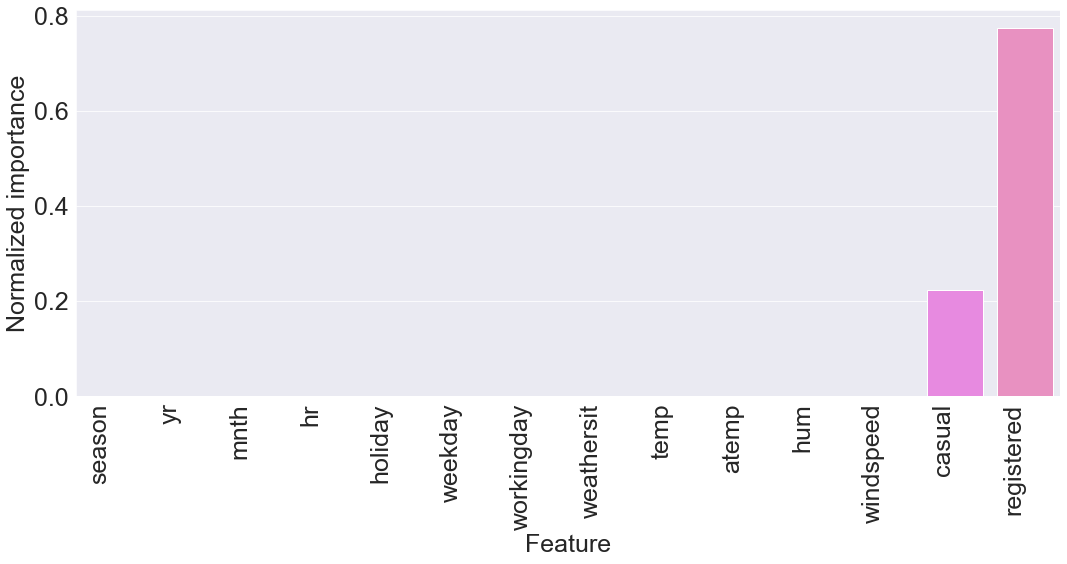

In [83]:
ax=sns.barplot(x=data.iloc[:,:-1].columns,y=normalize(feature_importance))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.xlabel('Feature')
plt.ylabel('Normalized importance')
plt.show()

### Naive Inductive Conformal Prediction Regression steps

1. Train a model $f:\mathbb{R}^d \rightarrow \mathbb{R}$ on the training dataset $D_{train} = \left\{(x_i,y_i)\right\}_{i=1}^{n_{train}}$
2. Define the score function as $s(x,y)= |f(x)-y|$
3. For every $(x_i,y_i) \in D_{cal}$, compute $s_i=s(x_i,y_i)$, where $D_{cal}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal}}$ is the calibration data set.
4. Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_{cal}} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
[f(x_i)- \hat{q},f(x_i)+ \hat{q}]
\end{equation}

**Problem:** This guarantees coverage property, however, the forecast interval dimension is independent of x and its dimension is always $2\hat{q}$.




In [84]:
def calculate_q_yhat_naive(models,X_cal,y_cal,T,alpha=0.1):
    # Calculate T q_yhats, one per each trial
    
    q_yhat_T_runs=[]
    
    
    for i in range(T):
        f_cal=models[i].predict(X_cal)
        y_pred=f_cal[1].flatten()
        N=len(y_cal)
        q_yhat=np.quantile(np.abs(y_cal-y_pred),np.ceil((N+1)*(1-alpha))/N)
        q_yhat_T_runs.append(q_yhat)
    
    return q_yhat_T_runs,np.mean(q_yhat_T_runs),models

In [85]:
q_yhat_T_runs,q_yhat_mean,models=calculate_q_yhat_naive(models,X_cal,y_cal,T,alpha=0.1)

In [86]:
models[0].summary()

Model: "model_113"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_114 (InputLayer)         [(None, 14)]         0           []                               
                                                                                                  
 dense_339 (Dense)              (None, 100)          1500        ['input_114[0][0]']              
                                                                                                  
 dense_340 (Dense)              (None, 50)           5050        ['dense_339[0][0]']              
                                                                                                  
 dense_341 (Dense)              (None, 25)           1275        ['dense_340[0][0]']              
                                                                                          

In [87]:
q_yhat_mean

1.1683928490925164

In [88]:
def calculate_performance(lower_bound,upper_bound,y_true,y_pred,alpha=0.1):
    #calculate coverage
    
    out_of_bounds=0
    N=len(y_true)
    
    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bounds+=1
        
    
    
    return 1-out_of_bounds/N


In [108]:
coverages=np.zeros(T)
interval_widths=[]

for i in range(T):
    f_val=models[i].predict(X_val)[1].flatten()
    interval_widths.append(f_val+q_yhat_T_runs[i]-(f_val-q_yhat_T_runs[i]))
    coverages[i]=calculate_performance(f_val-q_yhat_T_runs[i],f_val+q_yhat_T_runs[i],y_val,f_val)
    print('Iteration '+str(i+1),' with a coverage of {}'.format(coverages[i]))

lst_coverages.append(summary_statistics(coverages))



print('Median coverage of {}'.format(np.median(coverages)))

Iteration 1  with a coverage of 0.9081703107019563
Iteration 2  with a coverage of 0.8922899884925202
Iteration 3  with a coverage of 0.8929804372842347
Iteration 4  with a coverage of 0.9097813578826237
Iteration 5  with a coverage of 0.896662830840046
Iteration 6  with a coverage of 0.9040276179516686
Iteration 7  with a coverage of 0.8962025316455696
Iteration 8  with a coverage of 0.9021864211737629
Iteration 9  with a coverage of 0.9017261219792865
Iteration 10  with a coverage of 0.896662830840046
Iteration 11  with a coverage of 0.894361334867664
Iteration 12  with a coverage of 0.8975834292289988
Iteration 13  with a coverage of 0.897813578826237
Iteration 14  with a coverage of 0.8998849252013809
Iteration 15  with a coverage of 0.8962025316455696
Iteration 16  with a coverage of 0.9058688147295743
Iteration 17  with a coverage of 0.9008055235903337
Iteration 18  with a coverage of 0.9017261219792865
Iteration 19  with a coverage of 0.8962025316455696
Iteration 20  with a cove

In [110]:
lst_results.append(summary_statistics(interval_widths))

### Conformalized Quantile Regression

Solution for the foregoing problem: **Quantile Regression** <br>

Quantile regression algorithm attempts to learn the $\alpha \in (0,1)$ quantile of $Y_{test}|X_{test} = x$ for each possible value of x.
For that purpose. we shall use the quantile loss, also known as pinball loss.


**Problem:** We only get a estimate of the real quantiles $\left[\hat{Q}_{\frac{\alpha}{2}}(x),\hat{Q}_{1-\frac{\alpha}{2}}(x)\right]$. Although this provides good coverage, it doesn't guarantee $1-\alpha$ coverage.

**Solution:** Conformalize it with s given by
$$s(x,y)=max\left(\hat{Q}_{\frac{\alpha}{2}}(x)-y,y-\hat{Q}_{1-\frac{\alpha}{2}}(x)\right)$$
* Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_2} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.

* Predict with $1-\alpha$ confidence as
\begin{equation}
\left[\hat{Q}_{\frac{\alpha}{2}}(x)-\hat{q},\hat{Q}_{1-\frac{\alpha}{2}}(x)+\hat{q} \right]
\end{equation}

In [91]:
coverages=np.zeros(T)
interval_widths=[]

for i in range(T):
    f_val=models[i].predict(X_val)
    lower_bound=f_val[0].flatten()
    upper_bound=f_val[2].flatten()
    y_pred=f_val[1].flatten()
    interval_widths.append(np.abs(upper_bound-lower_bound))
    coverages[i]=calculate_performance(lower_bound,upper_bound,y_val,y_pred)
    print('Iteration '+str(i+1),' with a coverage of '+ str(coverages[i]),' and a median width of '+str(np.median(interval_widths[i])))

lst_coverages.append(summary_statistics(coverages))

print('Median QR coverage without conformal of '+ str(np.median(coverages))+ ' and a median width of '+str(np.median(interval_widths)))

Iteration 1  with a coverage of 0.9675489067894131  and a median width of 1.64888
Iteration 2  with a coverage of 0.9857307249712313  and a median width of 2.51268
Iteration 3  with a coverage of 0.9924050632911392  and a median width of 3.5233383
Iteration 4  with a coverage of 0.9981588032220944  and a median width of 4.8871155
Iteration 5  with a coverage of 0.5539700805523591  and a median width of 2.2904053
Iteration 6  with a coverage of 0.9799769850402762  and a median width of 1.8973694
Iteration 7  with a coverage of 0.9942462600690449  and a median width of 2.8281136
Iteration 8  with a coverage of 0.9926352128883774  and a median width of 4.4577637
Iteration 9  with a coverage of 0.9974683544303797  and a median width of 1.6673584
Iteration 10  with a coverage of 0.9268124280782508  and a median width of 3.6623993
Iteration 11  with a coverage of 0.8807825086306099  and a median width of 4.4884796
Iteration 12  with a coverage of 0.9795166858457998  and a median width of 4.5

Iteration 99  with a coverage of 0.08469505178365933  and a median width of 1.3572831
Iteration 100  with a coverage of 0.9871116225546606  and a median width of 4.1815186
Median QR coverage without conformal of 0.9874568469505178 and a median width of 2.682456


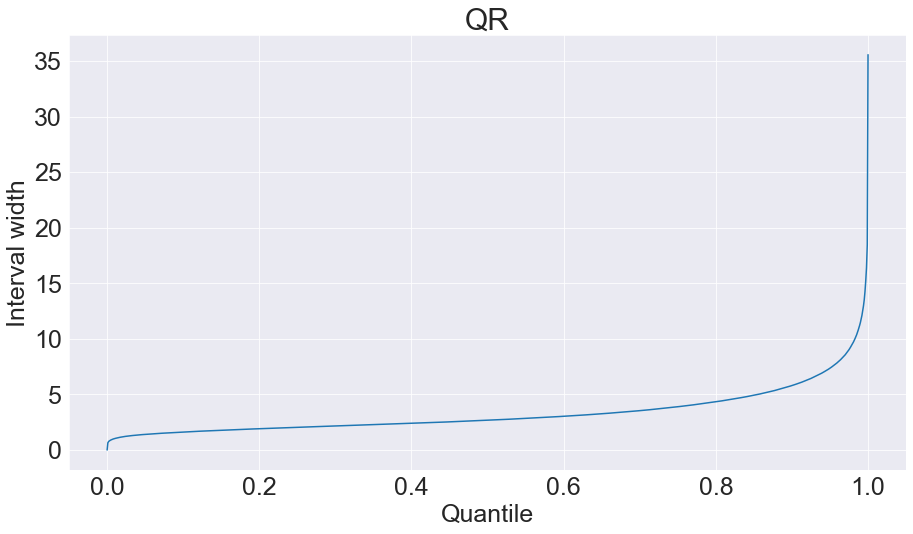

In [92]:
interval_widths=np.array(interval_widths).flatten()
xx=np.linspace(0,1,1000)
plt.plot(xx,np.quantile(interval_widths,xx))
plt.title('QR')
plt.xlabel('Quantile')
plt.ylabel('Interval width')
lst_results.append(summary_statistics(interval_widths))

### Calibration step (QR)

In [93]:
def calibrate_qyhat(y_true,lower_bound,upper_bound,alpha=0.1):
    # Calculate q_yhat for QR (CQR)
    
    N=len(y_true)
    s=np.amax([lower_bound-y_true,y_true-upper_bound],axis=0)
    q_yhat=np.quantile(s,np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat

q_yhats=np.zeros(T)
interval_widths=[]
coverages=np.zeros(T)

for i in range(T):
    forecast=models[i].predict(X_cal)
    lower_bound=forecast[0].flatten()
    upper_bound=forecast[2].flatten()

    q_yhat=calibrate_qyhat(y_cal,lower_bound,upper_bound)
    q_yhats[i]=q_yhat
    forecast=models[i].predict(X_val)
    lower_bound=forecast[0].flatten()-q_yhat
    upper_bound=forecast[2].flatten()+q_yhat
    y_pred=forecast[1].flatten()
    interval_widths.append(np.abs(upper_bound-lower_bound))
    coverages[i]=calculate_performance(lower_bound,upper_bound,y_val,y_pred)
    print('Iteration '+str(i+1),' with a coverage of '+ str(coverages[i]),' and a median width of '+str(np.median(interval_widths[i])))

lst_coverages.append(summary_statistics(coverages))

print('Median CQR coverage without conformal of '+ str(np.median(coverages))+ ' and a median width of '+str(np.median(interval_widths)))

Iteration 1  with a coverage of 0.9058688147295743  and a median width of 1.1265411
Iteration 2  with a coverage of 0.8980437284234752  and a median width of 1.8931732
Iteration 3  with a coverage of 0.9031070195627158  and a median width of 2.639183
Iteration 4  with a coverage of 0.903337169159954  and a median width of 2.8714294
Iteration 5  with a coverage of 0.9010356731875719  and a median width of 2.820984
Iteration 6  with a coverage of 0.9010356731875719  and a median width of 1.4977417
Iteration 7  with a coverage of 0.8980437284234752  and a median width of 1.3977776
Iteration 8  with a coverage of 0.9054085155350978  and a median width of 3.0495605
Iteration 9  with a coverage of 0.8964326812428078  and a median width of 1.020752
Iteration 10  with a coverage of 0.9028768699654776  and a median width of 3.5769806
Iteration 11  with a coverage of 0.8980437284234752  and a median width of 4.5609283
Iteration 12  with a coverage of 0.8948216340621404  and a median width of 4.2

Iteration 98  with a coverage of 0.8982738780207135  and a median width of 2.8283386
Iteration 99  with a coverage of 0.9005753739930955  and a median width of 3.3624282
Iteration 100  with a coverage of 0.9017261219792865  and a median width of 2.5720215
Median CQR coverage without conformal of 0.9002301495972382 and a median width of 2.2023785


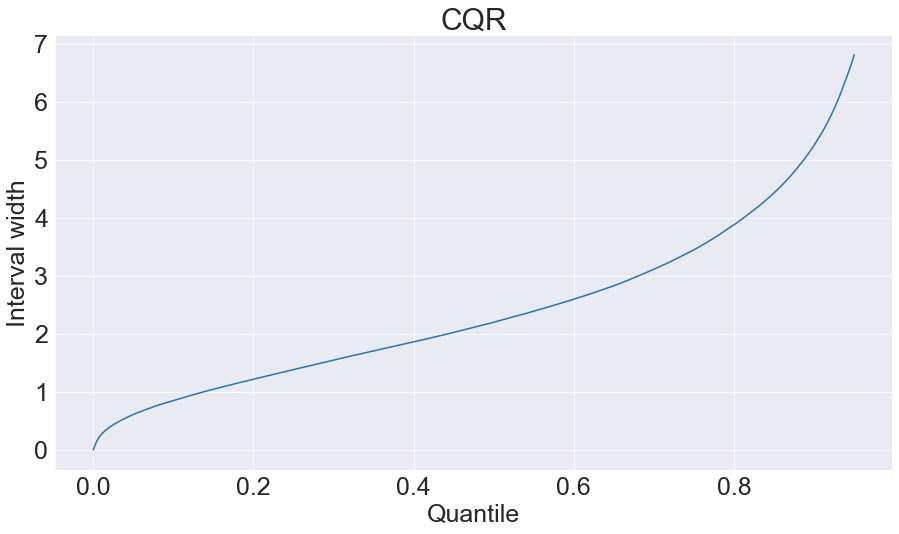

In [95]:
interval_widths=np.array(interval_widths).flatten()
xx=np.linspace(0,0.95,1000)
plt.plot(xx,np.quantile(interval_widths,xx))
plt.title('CQR')
plt.xlabel('Quantile')
plt.ylabel('Interval width')
lst_results.append(summary_statistics(interval_widths))

### Improved conformalized quantile regression (ICQR)

In [96]:
def optimized_kmeans(X,desired_variance,feature_importance,max_number_of_clusters):
    
    scores=[]
    
    mean_point=np.mean(X*feature_importance,axis=0)
    SSE=np.sum((X*feature_importance-mean_point)**2)
    i=1
    variance=0
    
    while variance < desired_variance and i< max_number_of_clusters:
        km =  KMeans(n_clusters=i+1, random_state=0).fit(X*feature_importance)
        centroids=km.cluster_centers_
        
        clusters=km.labels_
        
        SSE_between=0
        
        for j in range(len(np.unique(clusters))):
            n_k=X[clusters==j,:].shape[0]
            
            SSE_between+=n_k*np.sum((centroids[j]-mean_point)**2)
        
        variance=SSE_between/SSE
        
        scores.append([i+1,variance])
        i+=1
    
    scores=np.array(scores)
    
    best_k=i
    plt.axvline(x=best_k, color='r', linestyle='--')
    plt.plot(scores[:,0],scores[:,1])
    plt.xlabel('#clusters')
    plt.ylabel('Explained variance')
    plt.show()
    
    km =  KMeans(n_clusters=i, random_state=0).fit(X*feature_importance)
    
    return km,best_k

In [97]:
def CQR_qyhats_per_group(models,X_train,y_train,X_cal,y_cal,desired_variance,max_number_of_clusters,T,feature_importance,alpha=0.1):
    
    #models=QuantileRegressionModel(X_train,y_train,T)
    km,best_k=optimized_kmeans(X_train,desired_variance,feature_importance,max_number_of_clusters)
    q_yhats_T_runs=np.zeros((T,best_k))
    
    for j in tqdm(range(T)):
        
        f_cal=models[j].predict(X_cal)
        f_cal_upper=f_cal[2].flatten()
        f_cal_lower=f_cal[0].flatten()

        q_yhats=np.zeros(best_k)
        nrows=X_cal.shape[0]
        clusters=km.predict(X_cal*feature_importance)
        
        scores=[]

        for i in range(best_k):
            scores.append([])

        for i in range(nrows):
            scores[clusters[i]].append(max(f_cal_lower[i]-y_cal[i],y_cal[i]-f_cal_upper[i]))


        for i in range(best_k):
            N=len(scores[i])
            if N>0:
                q_yhats[i]=np.quantile(scores[i],min(np.ceil((N+1)*(1-alpha))/N,1))
        
        q_yhats_T_runs[j,:]= q_yhats
    
    return models,q_yhats_T_runs,km

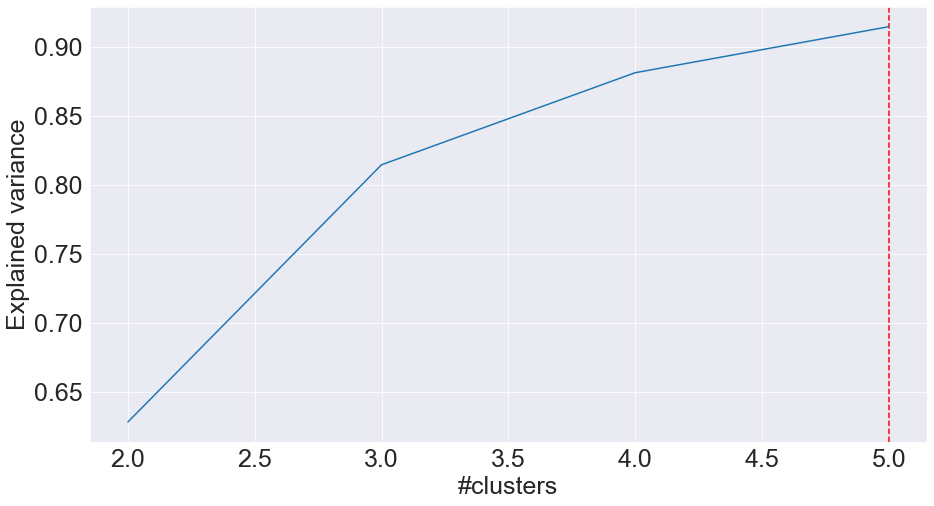

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.13it/s]


In [98]:
models,q_yhats_T_runs,km=CQR_qyhats_per_group(models,X_train,y_train,X_cal,y_cal,0.9,50,T,feature_importance)

In [99]:
np.mean(q_yhats_T_runs,axis=0)

array([-1.09310996, -0.49083649, -1.46657851, -0.22496988, -0.76013255])

In [100]:
def ConditionalCQR_calculate_bounds(model,q_yhats,km,X_val,y_val,feature_importance):
    
    f_val=model.predict(X_val)
    f_val_upper=f_val[2].flatten()
    f_val_lower=f_val[0].flatten()
    
    nrows=X_val.shape[0]
    lower_bound=np.zeros(nrows)
    upper_bound=np.zeros(nrows)
    assigned_cluster=km.predict(X_val*feature_importance)
    
    for i in range(nrows):
        lower_bound[i]=f_val_lower[i]-q_yhats[assigned_cluster[i]]
        upper_bound[i]=f_val_upper[i]+q_yhats[assigned_cluster[i]]
        

            
    return lower_bound,upper_bound,f_val[1].flatten()

In [101]:
q_yhats_T_runs.shape

(100, 5)

Iteration 1  with a coverage of 0.8948216340621404  and a median width of 1.0053113554090203
Iteration 2  with a coverage of 0.9037974683544304  and a median width of 1.9426174269866578
Iteration 3  with a coverage of 0.9026467203682393  and a median width of 2.0202430500881974
Iteration 4  with a coverage of 0.9065592635212888  and a median width of 1.5760112736283283
Iteration 5  with a coverage of 0.8991944764096663  and a median width of 2.431422433620554
Iteration 6  with a coverage of 0.8980437284234752  and a median width of 1.4375738638203313
Iteration 7  with a coverage of 0.9081703107019563  and a median width of 1.2286616624855355
Iteration 8  with a coverage of 0.9070195627157652  and a median width of 2.3297239419890623
Iteration 9  with a coverage of 0.897813578826237  and a median width of 0.9634634815242862
Iteration 10  with a coverage of 0.9012658227848102  and a median width of 2.6887825840340156
Iteration 11  with a coverage of 0.8918296892980437  and a median width

Iteration 89  with a coverage of 0.906789413118527  and a median width of 1.6471038163891762
Iteration 90  with a coverage of 0.9058688147295743  and a median width of 0.9980331311820692
Iteration 91  with a coverage of 0.8945914844649022  and a median width of 1.3820530705335656
Iteration 92  with a coverage of 0.905638665132336  and a median width of 0.83581835055179
Iteration 93  with a coverage of 0.9060989643268125  and a median width of 1.8118097791603418
Iteration 94  with a coverage of 0.8934407364787111  and a median width of 2.448325580503882
Iteration 95  with a coverage of 0.8996547756041426  and a median width of 3.679417386710213
Iteration 96  with a coverage of 0.9051783659378596  and a median width of 1.695992183796534
Iteration 97  with a coverage of 0.9065592635212888  and a median width of 1.5432151340409064
Iteration 98  with a coverage of 0.892059838895282  and a median width of 2.6420512604656494
Iteration 99  with a coverage of 0.914614499424626  and a median wid

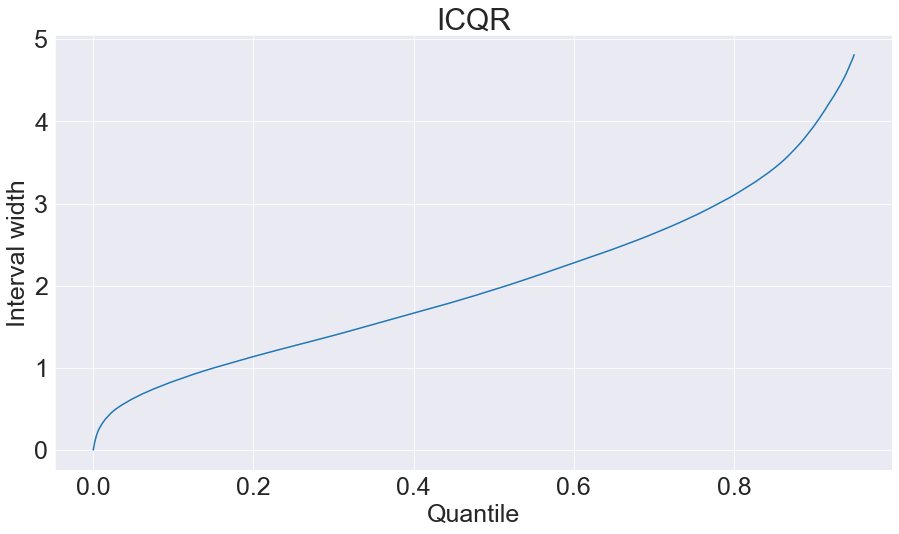

In [102]:
interval_widths=[]
coverages=np.zeros(T)

for i in range(T):
    lower_bound,upper_bound,y_pred=ConditionalCQR_calculate_bounds(models[i],q_yhats_T_runs[i],km,X_val,y_val,feature_importance)
    coverages[i]=calculate_performance(lower_bound,upper_bound,y_val,y_pred)
    interval_widths.append(np.abs(upper_bound-lower_bound))
    print('Iteration '+str(i+1),' with a coverage of '+ str(coverages[i]),' and a median width of '+str(np.median(interval_widths[i])))

lst_coverages.append(summary_statistics(coverages))
interval_widths=np.array(interval_widths).flatten()
xx=np.linspace(0,0.95,1000)
plt.plot(xx,np.quantile(interval_widths,xx))
plt.title('ICQR')
plt.xlabel('Quantile')
plt.ylabel('Interval width')
lst_results.append(summary_statistics(interval_widths))

print('Median ICQR coverage without conformal of '+ str(np.median(coverages))+ ' and a median width of '+str(np.median(interval_widths)))

In [113]:
df_width_results=pd.DataFrame(lst_results,columns=['min','max','mean','std','Q1','median','Q3','IQR'])
df_width_results

,min,max,mean,std,Q1,median,Q3,IQR
0,0.427124,7.491333,2.336785,1.362940,1.327354,2.135223,3.189590,1.862236
1,0.001831,35.566101,3.324998,2.115591,2.047175,2.682456,3.896203,1.849028
2,0.000229,36.159119,2.763314,2.186563,1.385670,2.202379,3.450058,2.064388
3,0.000165,25.988984,2.249955,1.470346,1.267076,1.949806,2.848970,1.581894


In [114]:
print(df_width_results.to_latex(index=False)) 

\begin{tabular}{rrrrrrrr}
\toprule
     min &       max &     mean &      std &       Q1 &   median &       Q3 &      IQR \\
\midrule
0.427124 &  7.491333 & 2.336785 & 1.362940 & 1.327354 & 2.135223 & 3.189590 & 1.862236 \\
0.001831 & 35.566101 & 3.324998 & 2.115591 & 2.047175 & 2.682456 & 3.896203 & 1.849028 \\
0.000229 & 36.159119 & 2.763314 & 2.186563 & 1.385670 & 2.202379 & 3.450058 & 2.064388 \\
0.000165 & 25.988984 & 2.249955 & 1.470346 & 1.267076 & 1.949806 & 2.848970 & 1.581894 \\
\bottomrule
\end{tabular}



In [105]:
df_coverages=pd.DataFrame(lst_coverages,columns=['min','max','mean','std','Q1','median','Q3','IQR'])
df_coverages

,min,max,mean,std,Q1,median,Q3,IQR
0,0.891139,0.915535,0.900700,0.004449,0.897583,0.900575,0.903625,0.006041
1,0.084695,1.000000,0.897445,0.193131,0.887687,0.987457,0.995224,0.107537
2,0.887227,0.910702,0.900242,0.005158,0.897756,0.900230,0.904028,0.006272
3,0.889068,0.916686,0.902656,0.006272,0.897986,0.902762,0.906847,0.008861


In [106]:
print(df_coverages.to_latex(index=False)) 

\begin{tabular}{rrrrrrrr}
\toprule
     min &      max &     mean &      std &       Q1 &   median &       Q3 &      IQR \\
\midrule
0.891139 & 0.915535 & 0.900700 & 0.004449 & 0.897583 & 0.900575 & 0.903625 & 0.006041 \\
0.084695 & 1.000000 & 0.897445 & 0.193131 & 0.887687 & 0.987457 & 0.995224 & 0.107537 \\
0.887227 & 0.910702 & 0.900242 & 0.005158 & 0.897756 & 0.900230 & 0.904028 & 0.006272 \\
0.889068 & 0.916686 & 0.902656 & 0.006272 & 0.897986 & 0.902762 & 0.906847 & 0.008861 \\
\bottomrule
\end{tabular}

